In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.23.2


<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{new} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [3]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- Functions:
    - <b>kl_divergence:</b> compute the Kullback-Leibler divergence of the Discriminator network.
        - <b>parameters:</b>
            - <b>probability:</b> the probability of the discriminator network.
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batch to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network. In this approach, the noise vector is based in a normal distribution $N(0,1)$.
        - <b>return:</b>
            - <b>gen_loss:</b> the batch loss in the generator network.
            - <b>dis_loss:</b> the batch loss in the discriminator network.
    - <b>plot_results:</b> this function plots four different figures. 1) the cost function of the arquitecture. 2) the kullback-leibler divergence. 3) the precision of the D network. 4) the 2-PCA representation of the synthetic samples.
        - <b>parameters:</b>
            - <b>syn_size:</b> the number of synthetic samples to be generated.
        - <b>return:</b> 
            - <b>p:</b> plot containing the four figures.

In [4]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
        self.X_train = None
        self.G = None
        self.D = None
        self.noise_input = None
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def binary_cross_entropy(self, prediction, target):
        """
        compute the loss for binary clasification problems
        """
        prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
        return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

    @tf.function
    def train_step(self, sample, batch_size, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = self.G(noise, training=True)

            real_output = self.D(sample, training=True)
            fake_output = self.D(synthetic_data, training=True)

            gen_loss = self.binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(self.binary_cross_entropy(real_output, tf.ones_like(real_output)) + self.binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, self.G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, self.D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, self.G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, self.D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, optimizerG, optimizerD):
        #reset metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batch_g_loss = []
        batch_d_loss = []
        self.G, self.D = G, D
        self.noise_input = noise_input
        self.X_train = dataset
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                batch_g_loss, batch_d_loss = self.train_step(batch, batch_size, noise_input,
                                                             optimizerG, optimizerD)
            self.accumulated_dloss.append(tf.reduce_mean(batch_d_loss))
            self.accumulated_gloss.append(tf.reduce_mean(batch_g_loss))

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs,
                                                                             self.accumulated_gloss[-1],
                                                                             self.accumulated_dloss[-1],
                                                                             t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        
    def plot_results(self, syn_size):
        fig = plt.figure(figsize=(15,10))
        for i in range(4):
            plt.subplot(2,2, i+1)
            if i==0:
                rr = range(0,len(self.accumulated_gloss), 3)
                short_g_loss = [self.accumulated_gloss[i] for i in rr]
                short_d_loss = [self.accumulated_dloss[i] for i in rr]
                plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
                plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
                plt.xlabel("Epochs", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(axis="y")
                plt.legend();
            elif i==1:
                plt.title("Divergencia de Kullback-Leibler", fontsize=14)
                plt.plot(range(len(self.kl_d)), self.kl_d, linewidth=.5)
                plt.plot(range(len(self.kl_d)), np.zeros(len(self.kl_d)))
                plt.grid()
                plt.xlabel("Epochs");
                plt.ylabel("Divergencia de Kullback-Leibler");
            elif i==2:
                short_precision = [self.precision[v] for v in rr]
                plt.plot(rr, short_precision, linewidth=.8, label="precision")
                plt.grid(axis="y")
                plt.plot(rr, np.ones(len(short_precision))*.5,
                         label="target", linestyle="--")
                plt.legend();
            elif i==3:
                pca = PCA(n_components=2)
                X_real_pca = pca.fit_transform(self.X_train.numpy())
                noise = tf.random.normal([syn_size, self.noise_input])
                synthetics = self.G(noise)
                X_fake_pca = pca.transform(synthetics.numpy())
                plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
                           edgecolors="red");
                plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
                            edgecolors="black");
        return fig
    
    
    def get_metrics(self, num_iter):
        """
        this function returns the metrics obtained after
        training the architecture
        num_iter: number of iterations to compute the boxplot
        return: precision of the discriminator network, Kullback-Leibler divergence
                loss of the generator network, loss of the discriminator network
        """
        precision_d = []
        kld_divergence = []
        g_loss = []
        d_loss = []
        for i in range(num_iter):
            noise = tf.random.normal([self.X_train.shape[0], self.noise_input])
            synthetic_samples = self.G(noise)
            X_comb = tf.concat([self.X_train, synthetic_samples], axis=0)
            y_comb = tf.concat([tf.ones((self.X_train.shape[0],1), dtype=tf.float64),
                                tf.zeros((synthetic_samples.shape[0],1), dtype=tf.float64)], axis=0)
            y_proba = self.D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            precision_d.append(precision_score(y_comb.numpy(), y_predict))
            kld_divergence.append(self.kl_divergence(y_proba).numpy())
            g_loss.append(self.binary_cross_entropy(self.D(synthetic_samples),
                                                    tf.zeros(synthetic_samples.shape[0], dtype=tf.float64)).numpy())
            d_loss.append(self.binary_cross_entropy(y_proba, y_comb).numpy())
            
        return precision_d, kld_divergence, g_loss, d_loss

In [5]:
#----------------------------------------------------------
#-------------- bokeh_utils class -------------------------
#----------------------------------------------------------
class bokeh_utils:
    """
    this class contains functions to facilitate the use of the bokeh library
    """
    def __init__(self):
        pass
    
    def boxtplot_values(self, v):  
        """
        This function returns the values to plot a boxplot in the bokeh library
        parameters: 
            v: array with the values to make a boxplot
        return: [lower, quantile25, quantile50, quantile75, upper] and outliers
        """
        q25 = np.quantile(v, q=.25, interpolation="midpoint")
        q50 = np.quantile(v, q=.5, interpolation="midpoint")
        q75 = np.quantile(v, q=.75, interpolation="midpoint")
        lower = q25 - 1.5*(q75-q25)
        upper = q75 + 1.5*(q75-q25)
        #outliers
        outliers = v[(v<lower)|(v>upper)]

        return [lower, q25, q50, q75, upper], outliers

###  Test

In [6]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [7]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [8]:
X_train = tf.Variable(np.array(X_train))

In [9]:
noise_input = 50

In [10]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [11]:
G = Sequential()
G.add(Dense(noise_input, input_shape=(noise_input,)))
G.add(Dense(50)) #64
G.add(Dense(150)) #64
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(32, input_shape=(9,)))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(Dense(32))
#D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(1, activation='sigmoid'))

In [12]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,noise_input], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
#print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.4222996]], shape=(1, 1), dtype=float64)


In [13]:
batch_size = 20
ep = 1700
#optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

optimizerG = tf.optimizers.SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [14]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.809734] :: D_loss[0.631654] :: time:1.062641[s]
epochs[1:1700] :: G_loss[0.750805] :: D_loss[0.658856] :: time:0.008543[s]
epochs[2:1700] :: G_loss[0.692196] :: D_loss[0.684506] :: time:0.008522[s]
epochs[3:1700] :: G_loss[0.686672] :: D_loss[0.686066] :: time:0.008473[s]
epochs[4:1700] :: G_loss[0.750493] :: D_loss[0.652433] :: time:0.008534[s]
epochs[5:1700] :: G_loss[0.806013] :: D_loss[0.636186] :: time:0.008346[s]
epochs[6:1700] :: G_loss[0.754706] :: D_loss[0.657781] :: time:0.008353[s]
epochs[7:1700] :: G_loss[0.746838] :: D_loss[0.658214] :: time:0.008356[s]
epochs[8:1700] :: G_loss[0.665171] :: D_loss[0.690911] :: time:0.008533[s]
epochs[9:1700] :: G_loss[0.747177] :: D_loss[0.650467] :: time:0.008563[s]
epochs[10:1700] :: G_loss[0.744148] :: D_loss[0.652186] :: time:0.008473[s]
epochs[11:1700] :: G_loss[0.671481] :: D_loss[0.687975] :: time:0.008505[s]
epochs[12:1700] :: G_loss[0.740057] :: D_loss[0.664191] :: time:0.008427[s]
epochs[13:1700] :: G_l

epochs[114:1700] :: G_loss[0.764932] :: D_loss[0.588303] :: time:0.010134[s]
epochs[115:1700] :: G_loss[0.728477] :: D_loss[0.617945] :: time:0.009741[s]
epochs[116:1700] :: G_loss[0.718590] :: D_loss[0.611737] :: time:0.010879[s]
epochs[117:1700] :: G_loss[0.738476] :: D_loss[0.606372] :: time:0.015553[s]
epochs[118:1700] :: G_loss[0.865195] :: D_loss[0.562467] :: time:0.009535[s]
epochs[119:1700] :: G_loss[0.801228] :: D_loss[0.583278] :: time:0.013379[s]
epochs[120:1700] :: G_loss[0.751271] :: D_loss[0.603027] :: time:0.009008[s]
epochs[121:1700] :: G_loss[0.734467] :: D_loss[0.626648] :: time:0.008879[s]
epochs[122:1700] :: G_loss[0.792957] :: D_loss[0.574177] :: time:0.009165[s]
epochs[123:1700] :: G_loss[0.676075] :: D_loss[0.645957] :: time:0.008783[s]
epochs[124:1700] :: G_loss[0.753287] :: D_loss[0.603937] :: time:0.008672[s]
epochs[125:1700] :: G_loss[0.674061] :: D_loss[0.624422] :: time:0.008326[s]
epochs[126:1700] :: G_loss[0.795587] :: D_loss[0.575275] :: time:0.008500[s]

epochs[238:1700] :: G_loss[0.794218] :: D_loss[0.593101] :: time:0.010127[s]
epochs[239:1700] :: G_loss[0.864586] :: D_loss[0.555723] :: time:0.014092[s]
epochs[240:1700] :: G_loss[0.915735] :: D_loss[0.546381] :: time:0.009319[s]
epochs[241:1700] :: G_loss[0.850603] :: D_loss[0.556628] :: time:0.012100[s]
epochs[242:1700] :: G_loss[0.842887] :: D_loss[0.558922] :: time:0.009478[s]
epochs[243:1700] :: G_loss[0.863504] :: D_loss[0.556363] :: time:0.009228[s]
epochs[244:1700] :: G_loss[0.818074] :: D_loss[0.581761] :: time:0.008968[s]
epochs[245:1700] :: G_loss[0.827938] :: D_loss[0.561769] :: time:0.009137[s]
epochs[246:1700] :: G_loss[0.811651] :: D_loss[0.585277] :: time:0.008527[s]
epochs[247:1700] :: G_loss[0.918600] :: D_loss[0.531442] :: time:0.009711[s]
epochs[248:1700] :: G_loss[0.849400] :: D_loss[0.555198] :: time:0.008810[s]
epochs[249:1700] :: G_loss[0.817836] :: D_loss[0.571815] :: time:0.008337[s]
epochs[250:1700] :: G_loss[0.826958] :: D_loss[0.572837] :: time:0.008634[s]

epochs[365:1700] :: G_loss[0.861355] :: D_loss[0.559140] :: time:0.010464[s]
epochs[366:1700] :: G_loss[0.846128] :: D_loss[0.581771] :: time:0.010660[s]
epochs[367:1700] :: G_loss[0.779945] :: D_loss[0.597230] :: time:0.008790[s]
epochs[368:1700] :: G_loss[0.961481] :: D_loss[0.525004] :: time:0.009560[s]
epochs[369:1700] :: G_loss[0.890793] :: D_loss[0.577420] :: time:0.008749[s]
epochs[370:1700] :: G_loss[0.984793] :: D_loss[0.535418] :: time:0.009160[s]
epochs[371:1700] :: G_loss[0.890346] :: D_loss[0.572771] :: time:0.008635[s]
epochs[372:1700] :: G_loss[0.846715] :: D_loss[0.572100] :: time:0.008810[s]
epochs[373:1700] :: G_loss[0.976278] :: D_loss[0.526289] :: time:0.008624[s]
epochs[374:1700] :: G_loss[0.868649] :: D_loss[0.553627] :: time:0.008950[s]
epochs[375:1700] :: G_loss[0.872543] :: D_loss[0.570583] :: time:0.008505[s]
epochs[376:1700] :: G_loss[0.841260] :: D_loss[0.605804] :: time:0.008841[s]
epochs[377:1700] :: G_loss[0.919892] :: D_loss[0.567100] :: time:0.008805[s]

epochs[474:1700] :: G_loss[0.826433] :: D_loss[0.597827] :: time:0.009182[s]
epochs[475:1700] :: G_loss[0.841486] :: D_loss[0.603319] :: time:0.010413[s]
epochs[476:1700] :: G_loss[0.872499] :: D_loss[0.584718] :: time:0.010309[s]
epochs[477:1700] :: G_loss[0.933615] :: D_loss[0.562847] :: time:0.008654[s]
epochs[478:1700] :: G_loss[0.811416] :: D_loss[0.608396] :: time:0.008418[s]
epochs[479:1700] :: G_loss[0.770022] :: D_loss[0.659497] :: time:0.008593[s]
epochs[480:1700] :: G_loss[0.776911] :: D_loss[0.652534] :: time:0.008346[s]
epochs[481:1700] :: G_loss[0.909226] :: D_loss[0.563235] :: time:0.008475[s]
epochs[482:1700] :: G_loss[0.800934] :: D_loss[0.619140] :: time:0.008813[s]
epochs[483:1700] :: G_loss[0.924377] :: D_loss[0.563070] :: time:0.008472[s]
epochs[484:1700] :: G_loss[0.823831] :: D_loss[0.624939] :: time:0.008485[s]
epochs[485:1700] :: G_loss[0.712716] :: D_loss[0.672443] :: time:0.008580[s]
epochs[486:1700] :: G_loss[0.794126] :: D_loss[0.629352] :: time:0.008501[s]

epochs[591:1700] :: G_loss[0.807749] :: D_loss[0.657076] :: time:0.009832[s]
epochs[592:1700] :: G_loss[0.854793] :: D_loss[0.629696] :: time:0.010845[s]
epochs[593:1700] :: G_loss[0.729499] :: D_loss[0.693387] :: time:0.008921[s]
epochs[594:1700] :: G_loss[0.698925] :: D_loss[0.696653] :: time:0.008427[s]
epochs[595:1700] :: G_loss[0.863704] :: D_loss[0.643110] :: time:0.008688[s]
epochs[596:1700] :: G_loss[0.780668] :: D_loss[0.679457] :: time:0.008489[s]
epochs[597:1700] :: G_loss[0.803314] :: D_loss[0.659940] :: time:0.008492[s]
epochs[598:1700] :: G_loss[0.751210] :: D_loss[0.674207] :: time:0.008661[s]
epochs[599:1700] :: G_loss[0.816030] :: D_loss[0.640350] :: time:0.008532[s]
epochs[600:1700] :: G_loss[0.716118] :: D_loss[0.721585] :: time:0.008504[s]
epochs[601:1700] :: G_loss[0.765246] :: D_loss[0.694214] :: time:0.008418[s]
epochs[602:1700] :: G_loss[0.836378] :: D_loss[0.652130] :: time:0.008457[s]
epochs[603:1700] :: G_loss[0.941614] :: D_loss[0.586605] :: time:0.008546[s]

epochs[707:1700] :: G_loss[0.713737] :: D_loss[0.727547] :: time:0.010011[s]
epochs[708:1700] :: G_loss[0.693911] :: D_loss[0.726775] :: time:0.010237[s]
epochs[709:1700] :: G_loss[0.693665] :: D_loss[0.734903] :: time:0.009706[s]
epochs[710:1700] :: G_loss[0.810814] :: D_loss[0.692976] :: time:0.008704[s]
epochs[711:1700] :: G_loss[0.747016] :: D_loss[0.704610] :: time:0.008554[s]
epochs[712:1700] :: G_loss[0.802354] :: D_loss[0.687914] :: time:0.008680[s]
epochs[713:1700] :: G_loss[0.775643] :: D_loss[0.697490] :: time:0.008525[s]
epochs[714:1700] :: G_loss[0.791838] :: D_loss[0.673473] :: time:0.008448[s]
epochs[715:1700] :: G_loss[0.776816] :: D_loss[0.699911] :: time:0.008563[s]
epochs[716:1700] :: G_loss[0.765351] :: D_loss[0.691166] :: time:0.008420[s]
epochs[717:1700] :: G_loss[0.733138] :: D_loss[0.718056] :: time:0.008413[s]
epochs[718:1700] :: G_loss[0.806765] :: D_loss[0.690108] :: time:0.008565[s]
epochs[719:1700] :: G_loss[0.723943] :: D_loss[0.707156] :: time:0.008372[s]

epochs[822:1700] :: G_loss[0.758715] :: D_loss[0.705233] :: time:0.009265[s]
epochs[823:1700] :: G_loss[0.688841] :: D_loss[0.733378] :: time:0.009635[s]
epochs[824:1700] :: G_loss[0.693293] :: D_loss[0.734603] :: time:0.010403[s]
epochs[825:1700] :: G_loss[0.755962] :: D_loss[0.706667] :: time:0.008861[s]
epochs[826:1700] :: G_loss[0.655366] :: D_loss[0.745164] :: time:0.008988[s]
epochs[827:1700] :: G_loss[0.681844] :: D_loss[0.742051] :: time:0.008842[s]
epochs[828:1700] :: G_loss[0.599539] :: D_loss[0.779647] :: time:0.008589[s]
epochs[829:1700] :: G_loss[0.714573] :: D_loss[0.718241] :: time:0.008706[s]
epochs[830:1700] :: G_loss[0.748377] :: D_loss[0.715261] :: time:0.008569[s]
epochs[831:1700] :: G_loss[0.802159] :: D_loss[0.687564] :: time:0.008671[s]
epochs[832:1700] :: G_loss[0.680538] :: D_loss[0.736933] :: time:0.008676[s]
epochs[833:1700] :: G_loss[0.654964] :: D_loss[0.749178] :: time:0.008603[s]
epochs[834:1700] :: G_loss[0.765557] :: D_loss[0.702959] :: time:0.008661[s]

epochs[937:1700] :: G_loss[0.660925] :: D_loss[0.746470] :: time:0.010117[s]
epochs[938:1700] :: G_loss[0.731350] :: D_loss[0.711569] :: time:0.011950[s]
epochs[939:1700] :: G_loss[0.723046] :: D_loss[0.715946] :: time:0.009961[s]
epochs[940:1700] :: G_loss[0.732130] :: D_loss[0.713930] :: time:0.008573[s]
epochs[941:1700] :: G_loss[0.756365] :: D_loss[0.703815] :: time:0.008842[s]
epochs[942:1700] :: G_loss[0.710457] :: D_loss[0.724200] :: time:0.008546[s]
epochs[943:1700] :: G_loss[0.720013] :: D_loss[0.719532] :: time:0.008623[s]
epochs[944:1700] :: G_loss[0.730460] :: D_loss[0.711579] :: time:0.008501[s]
epochs[945:1700] :: G_loss[0.685362] :: D_loss[0.735324] :: time:0.008535[s]
epochs[946:1700] :: G_loss[0.731006] :: D_loss[0.710447] :: time:0.008416[s]
epochs[947:1700] :: G_loss[0.714516] :: D_loss[0.720476] :: time:0.008460[s]
epochs[948:1700] :: G_loss[0.700769] :: D_loss[0.726335] :: time:0.008342[s]
epochs[949:1700] :: G_loss[0.711698] :: D_loss[0.724464] :: time:0.008383[s]

epochs[1052:1700] :: G_loss[0.705061] :: D_loss[0.724291] :: time:0.008659[s]
epochs[1053:1700] :: G_loss[0.717616] :: D_loss[0.715804] :: time:0.009871[s]
epochs[1054:1700] :: G_loss[0.770145] :: D_loss[0.692590] :: time:0.011099[s]
epochs[1055:1700] :: G_loss[0.644496] :: D_loss[0.751711] :: time:0.008723[s]
epochs[1056:1700] :: G_loss[0.742431] :: D_loss[0.707618] :: time:0.008816[s]
epochs[1057:1700] :: G_loss[0.741533] :: D_loss[0.708836] :: time:0.008542[s]
epochs[1058:1700] :: G_loss[0.764047] :: D_loss[0.694356] :: time:0.008528[s]
epochs[1059:1700] :: G_loss[0.694239] :: D_loss[0.727314] :: time:0.008569[s]
epochs[1060:1700] :: G_loss[0.724091] :: D_loss[0.714548] :: time:0.008476[s]
epochs[1061:1700] :: G_loss[0.776292] :: D_loss[0.691496] :: time:0.008656[s]
epochs[1062:1700] :: G_loss[0.806363] :: D_loss[0.679044] :: time:0.008504[s]
epochs[1063:1700] :: G_loss[0.722961] :: D_loss[0.714692] :: time:0.008571[s]
epochs[1064:1700] :: G_loss[0.737301] :: D_loss[0.708722] :: tim

epochs[1167:1700] :: G_loss[0.694555] :: D_loss[0.721794] :: time:0.009955[s]
epochs[1168:1700] :: G_loss[0.763669] :: D_loss[0.689598] :: time:0.011887[s]
epochs[1169:1700] :: G_loss[0.700486] :: D_loss[0.717571] :: time:0.009996[s]
epochs[1170:1700] :: G_loss[0.727960] :: D_loss[0.702383] :: time:0.008716[s]
epochs[1171:1700] :: G_loss[0.706368] :: D_loss[0.713158] :: time:0.009127[s]
epochs[1172:1700] :: G_loss[0.786811] :: D_loss[0.683031] :: time:0.009953[s]
epochs[1173:1700] :: G_loss[0.766368] :: D_loss[0.687527] :: time:0.008486[s]
epochs[1174:1700] :: G_loss[0.712827] :: D_loss[0.710034] :: time:0.008582[s]
epochs[1175:1700] :: G_loss[0.766280] :: D_loss[0.687138] :: time:0.008519[s]
epochs[1176:1700] :: G_loss[0.768201] :: D_loss[0.684000] :: time:0.008594[s]
epochs[1177:1700] :: G_loss[0.716647] :: D_loss[0.709008] :: time:0.008504[s]
epochs[1178:1700] :: G_loss[0.751610] :: D_loss[0.692633] :: time:0.010928[s]
epochs[1179:1700] :: G_loss[0.743530] :: D_loss[0.695421] :: tim

epochs[1282:1700] :: G_loss[0.712943] :: D_loss[0.698240] :: time:0.008584[s]
epochs[1283:1700] :: G_loss[0.671136] :: D_loss[0.719144] :: time:0.010060[s]
epochs[1284:1700] :: G_loss[0.780566] :: D_loss[0.668073] :: time:0.011055[s]
epochs[1285:1700] :: G_loss[0.737148] :: D_loss[0.689824] :: time:0.008831[s]
epochs[1286:1700] :: G_loss[0.711125] :: D_loss[0.700772] :: time:0.008759[s]
epochs[1287:1700] :: G_loss[0.759350] :: D_loss[0.678996] :: time:0.008621[s]
epochs[1288:1700] :: G_loss[0.714947] :: D_loss[0.698901] :: time:0.008479[s]
epochs[1289:1700] :: G_loss[0.695428] :: D_loss[0.709861] :: time:0.008574[s]
epochs[1290:1700] :: G_loss[0.731274] :: D_loss[0.691463] :: time:0.014158[s]
epochs[1291:1700] :: G_loss[0.724832] :: D_loss[0.695298] :: time:0.018327[s]
epochs[1292:1700] :: G_loss[0.728142] :: D_loss[0.693910] :: time:0.010791[s]
epochs[1293:1700] :: G_loss[0.711289] :: D_loss[0.702120] :: time:0.008606[s]
epochs[1294:1700] :: G_loss[0.797115] :: D_loss[0.664478] :: tim

epochs[1396:1700] :: G_loss[0.707562] :: D_loss[0.693524] :: time:0.010020[s]
epochs[1397:1700] :: G_loss[0.757048] :: D_loss[0.670701] :: time:0.010719[s]
epochs[1398:1700] :: G_loss[0.722618] :: D_loss[0.686137] :: time:0.009545[s]
epochs[1399:1700] :: G_loss[0.752434] :: D_loss[0.671761] :: time:0.008565[s]
epochs[1400:1700] :: G_loss[0.743989] :: D_loss[0.676061] :: time:0.011440[s]
epochs[1401:1700] :: G_loss[0.703235] :: D_loss[0.694549] :: time:0.008652[s]
epochs[1402:1700] :: G_loss[0.707148] :: D_loss[0.692515] :: time:0.008640[s]
epochs[1403:1700] :: G_loss[0.711772] :: D_loss[0.690165] :: time:0.008560[s]
epochs[1404:1700] :: G_loss[0.730450] :: D_loss[0.681953] :: time:0.008550[s]
epochs[1405:1700] :: G_loss[0.723953] :: D_loss[0.684119] :: time:0.008526[s]
epochs[1406:1700] :: G_loss[0.728036] :: D_loss[0.683672] :: time:0.008522[s]
epochs[1407:1700] :: G_loss[0.700279] :: D_loss[0.696485] :: time:0.008597[s]
epochs[1408:1700] :: G_loss[0.740525] :: D_loss[0.678598] :: tim

epochs[1511:1700] :: G_loss[0.756299] :: D_loss[0.677795] :: time:0.011497[s]
epochs[1512:1700] :: G_loss[0.746296] :: D_loss[0.682459] :: time:0.013416[s]
epochs[1513:1700] :: G_loss[0.776240] :: D_loss[0.667845] :: time:0.009048[s]
epochs[1514:1700] :: G_loss[0.754940] :: D_loss[0.677645] :: time:0.008664[s]
epochs[1515:1700] :: G_loss[0.734388] :: D_loss[0.685827] :: time:0.008578[s]
epochs[1516:1700] :: G_loss[0.738686] :: D_loss[0.684244] :: time:0.008839[s]
epochs[1517:1700] :: G_loss[0.744948] :: D_loss[0.681028] :: time:0.008599[s]
epochs[1518:1700] :: G_loss[0.754267] :: D_loss[0.676010] :: time:0.008479[s]
epochs[1519:1700] :: G_loss[0.726920] :: D_loss[0.687941] :: time:0.008492[s]
epochs[1520:1700] :: G_loss[0.755924] :: D_loss[0.675221] :: time:0.008437[s]
epochs[1521:1700] :: G_loss[0.738814] :: D_loss[0.682453] :: time:0.008469[s]
epochs[1522:1700] :: G_loss[0.744152] :: D_loss[0.679492] :: time:0.008505[s]
epochs[1523:1700] :: G_loss[0.737319] :: D_loss[0.682074] :: tim

epochs[1626:1700] :: G_loss[0.737612] :: D_loss[0.668051] :: time:0.011220[s]
epochs[1627:1700] :: G_loss[0.744193] :: D_loss[0.663089] :: time:0.011833[s]
epochs[1628:1700] :: G_loss[0.746340] :: D_loss[0.662848] :: time:0.009948[s]
epochs[1629:1700] :: G_loss[0.741596] :: D_loss[0.663729] :: time:0.008791[s]
epochs[1630:1700] :: G_loss[0.718823] :: D_loss[0.675864] :: time:0.008836[s]
epochs[1631:1700] :: G_loss[0.730536] :: D_loss[0.668279] :: time:0.008612[s]
epochs[1632:1700] :: G_loss[0.738126] :: D_loss[0.666293] :: time:0.008628[s]
epochs[1633:1700] :: G_loss[0.720028] :: D_loss[0.673828] :: time:0.008647[s]
epochs[1634:1700] :: G_loss[0.743319] :: D_loss[0.664466] :: time:0.008497[s]
epochs[1635:1700] :: G_loss[0.700540] :: D_loss[0.682303] :: time:0.008560[s]
epochs[1636:1700] :: G_loss[0.748843] :: D_loss[0.661373] :: time:0.008536[s]
epochs[1637:1700] :: G_loss[0.733588] :: D_loss[0.667883] :: time:0.008634[s]
epochs[1638:1700] :: G_loss[0.722991] :: D_loss[0.674807] :: tim

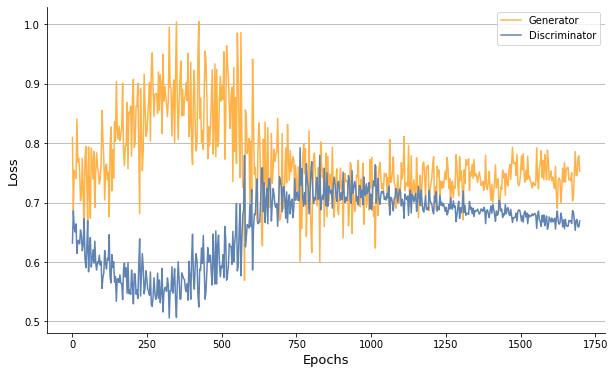

In [15]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

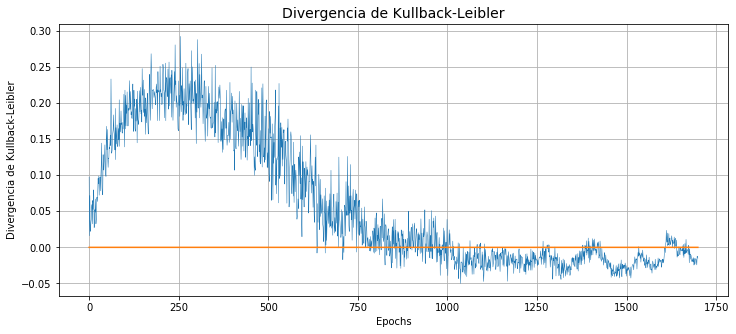

In [16]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

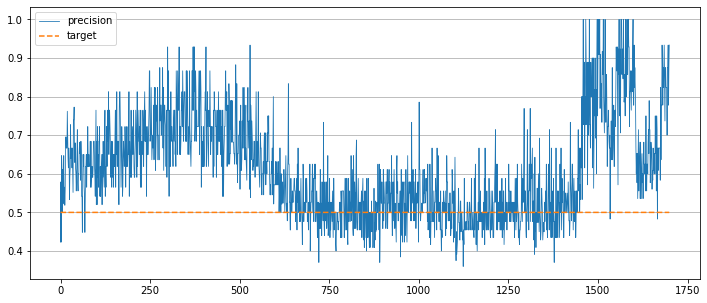

In [17]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(len(utils.precision)), utils.precision, linewidth=.8, label="precision")
plt.grid(axis="y")
plt.plot(range(len(utils.precision)), np.ones(len(utils.precision))*.5, label="target", linestyle="--")
plt.legend();

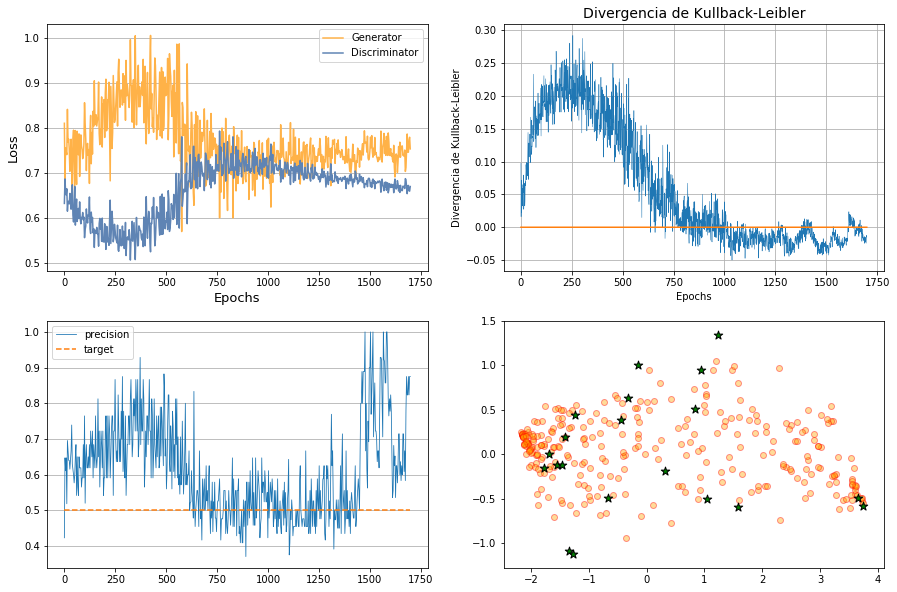

In [18]:
p = utils.plot_results(syn_size=300)

In [19]:
def boxtplot_values(v):
    """
    parameters: 
        v: array with the values to make a boxplot
    return the values to plot a boxplot in the bokeh library
    return: [lower, quantile25, quantile50, quantile75, upper] and outliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]

    return [lower, q25, q50, q75, upper], outliers

In [20]:
p_d, kld, l_g, l_d = utils.get_metrics(num_iter=300)

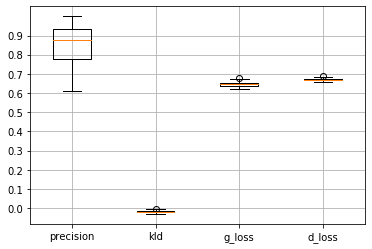

In [21]:
plt.boxplot([p_d, kld, l_g, l_d]);
#plt.yscale("logit")
plt.grid(axis="both");
plt.xticks(ticks=[1,2,3,4], labels=["precision", "kld", "g_loss", "d_loss"]);
plt.yticks(ticks=np.arange(0,1,.1), labels=np.round(np.arange(0,1.1,.1), 2));

#### Boxplot with Bokeh library
- I'm using the bokeh library to make a better plot.

In [22]:
from bokeh.plotting import output_notebook, figure, show, output_file
from bokeh.layouts import gridplot
from bokeh.palettes import OrRd, Greens, Set3, RdYlBu, YlGnBu
output_notebook()

[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(p_d))
[kldl, kldq1, kldq2, kldq3, kldu], kldouts = boxtplot_values(np.array(kld))
[lgl, lgq1, lgq2, lgq3, lgu], lgouts = boxtplot_values(np.array(l_g))
[ldl, ldq1, ldq2, ldq3, ldu], ldouts = boxtplot_values(np.array(l_d))

Loading BokehJS ...

In [23]:
#precision of the discriminator network
cats = ["Discriminador"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p.segment(cats, [pl], cats, [pq1], line_color="black")
p.segment(cats, [pq3], cats, [pu], line_color="black")
p.vbar(cats, 0.2, [pq1], [pq2], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.2, [pq2], [pq3], fill_color="#3B8686", line_color="black")
p.rect(cats, [pl], 0.2, 0.0001, line_color="black")
p.rect(cats, [pu], 0.2, 0.0001, line_color="black")
p.circle([cats[0] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p.legend.background_fill_alpha = 0.0
p.yaxis.axis_label = "Precisão"
#p.legend.location = (80, 100)

#Kullback-Leibler divergence
p1 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p1.segment(cats, [kldl], cats, [kldq1], line_color="black")
p1.segment(cats, [kldq3], cats, [kldu], line_color="black")
p1.vbar(cats, 0.23, [kldq1], [kldq2], fill_color=Set3[3][0], line_color="black")
p1.vbar(cats, 0.23, [kldq2], [kldq3], fill_color=Set3[3][2], line_color="black")
p1.rect(cats, [kldl], 0.2, 0.0001, line_color="black")
p1.rect(cats, [kldu], 0.2, 0.0001, line_color="black")
p1.circle([cats[0] for i in range(len(np.unique(kldouts)))], np.unique(kldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p1.legend.background_fill_alpha = 0.0
p1.yaxis.axis_label = "Divergência de Kullback-Leibler"

#cost function of the generator network
cats_g = ["Generador"]
p2 = figure(tools="", background_fill_color="#ffffff", x_range=cats_g, toolbar_location=None,
          plot_height=250, plot_width=220, )
p2.segment(cats_g, [lgl], cats_g, [lgq1], line_color="black")
p2.segment(cats_g, [lgq3], cats_g, [lgu], line_color="black")
p2.vbar(cats_g, 0.23, [lgq1], [lgq2], fill_color=RdYlBu[3][0], line_color="black")
p2.vbar(cats_g, 0.23, [lgq2], [lgq3], fill_color=RdYlBu[3][1], line_color="black")
p2.rect(cats_g, [lgl], 0.2, 0.0001, line_color="black")
p2.rect(cats_g, [lgu], 0.2, 0.0001, line_color="black")
p2.circle([cats_g[0] for i in range(len(np.unique(lgouts)))], np.unique(lgouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p2.legend.background_fill_alpha = 0.0
p2.yaxis.axis_label = "Função de custo"

#cost function of the discriminator network
p3 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p3.segment(cats, [ldl], cats, [ldq1], line_color="black")
p3.segment(cats, [ldq3], cats, [ldu], line_color="black")
p3.vbar(cats, 0.23, [ldq1], [ldq2], fill_color=YlGnBu[3][0], line_color="black")
p3.vbar(cats, 0.23, [ldq2], [ldq3], fill_color=YlGnBu[3][1], line_color="black")
p3.rect(cats, [ldl], 0.2, 0.0001, line_color="black")
p3.rect(cats, [ldu], 0.2, 0.0001, line_color="black")
p3.circle([cats[0] for i in range(len(np.unique(ldouts)))], np.unique(ldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p3.legend.background_fill_alpha = 0.0
p3.yaxis.axis_label = "Função de custo"


show(gridplot([[p, p1],[p2, p3]], plot_width=280))

#### Gaussian noise generator

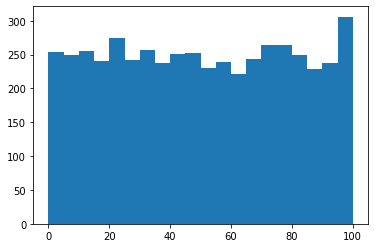

In [24]:
a = np.random.randint(0,101, size=5000)
plt.hist(a, bins=20);

In [90]:
class gaussian_noise_samples:
    """
    Gaussian noise samples allows generate synthetic samples based in a real samples.
    This method adds Gaussian noise to a real example.
    parameters:
        - mu: mean of the gaussian distribution
        - sigma: standard desviation of the gaussian distribution
    Methods:
        - get_syn_samples
    """
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def get_syn_samples(self, x, n):
        """
        Inputs:
            T: 2D-data array to be increase
            N: Percentage of synthetic samples N%.
        """
        if n < 100:
            idxs = np.random.choice(range(len(x)), size=int(len(x)*(n/100)), replace=False)
            x = x[idxs, :]
            n = 100
        
        n = int(n/100)*len(x)
        synthetic_samples = np.ones((n, x.shape[1]))
        #generating synthetic samples
        for i in range(n):
            #getting a random real sample
            idx = np.random.randint(0, x.shape[1])
            synthetic_samples[i] = x[idx] + np.random.normal(self.mu, self.sigma, size=(x.shape[1]))
    
        return synthetic_samples

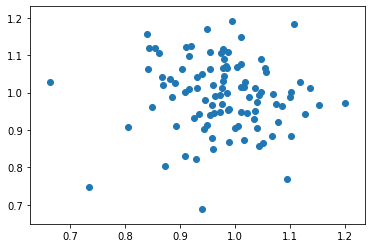

In [91]:
x = np.ones((100,2))*np.random.normal(1, .1, size=(100,2))
plt.scatter(x[:,0], x[:,1]);

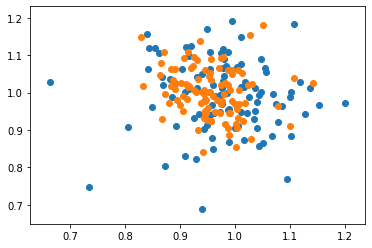

In [106]:
obj = gaussian_noise_samples(0,.05)
x_sin = obj.get_syn_samples(x, 150)
plt.scatter(x[:,0], x[:,1]);
plt.scatter(x_sin[:,0], x_sin[:,1]);

In [107]:
class metrics:
    """
    class to compute the similarity metrics between real and synthetic samples
    methods:
        - get_e_similarity
    """
    def __init__(self):
        self.error = None
        
    def get_e_similarity(self, real, synthetic):
        """
        this function calculates the metric E, this metric is a similarity metric
        based on the coefficient of variation of the synthetic samples plus
        the absolute distance between real and synthetic samples.
        Inputs:
            - real: 2D array with the real samples
            - synthetic: 2D array with the synthetic samples
        Return a similarity metric
        """
        assert real.shape[1]==synthetic.shape[1], "real and synthetic samples are not the same number of features"
        distance = []
        for g in range(real.shape[1]):
            distance.append(np.mean(abs(real[g,:] - synthetic)))
        cv = (np.std(synthetic,axis=1)/np.mean(synthetic,axis=1))
        #print(np.mean(cv))
        return np.mean(distance) + np.mean(cv)

In [108]:
metrics().get_e_similarity(x, x_sin)

0.04311218873858404


0.09986422847516793